## import

In [1]:
import logging
import os

import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LinearRegression


import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from autorank import autorank, plot_stats, create_report, latex_table
from pyirr import intraclass_correlation

pyro.__version__

'1.8.4'

In [2]:
!pwd

/Users/marcoghezzi/PycharmProjects/pythonProject/fear_gen/pyro/category_learning/sliding_window


In [3]:
from fear_gen import extract_correct_csv
os.chdir('../../../')
valid_sub = extract_correct_csv.extract_only_valid_subject()
os.chdir('pyro/category_learning/sliding_window')

In [4]:
def anxious_subjects(path, n, type='top'):
    '''

    :param path: path sias score or linear deviation score
    :param n: number of subjects
    :param type: 'top' or 'bot'
    :return: top or bot n subjects sorted by sias score
    '''
    valid_subjects = extract_correct_csv.extract_only_valid_subject()
    df = pd.read_csv(path).dropna().reset_index(drop=True)
    df = df[df.subject.isin(valid_subjects)]
    df['subject'] = [int(x) for x in df['subject']]
    if type=='top':
        return df.sort_values(by=df.columns[1], ascending=False).subject[:n].values
    else:
        return df.sort_values(by=df.columns[1], ascending=False).subject[-n:].values


In [5]:
def counter_window(data, k=0):
    N = data.shape[0]
    counter = torch.zeros((N,4))
    for i in range(len(data)):
        dict_ = {'[0 0]':0, '[0 1]': 0, '[1 0]':0, '[1 1]':0}
        if k == 0 or k > i:
            tmp_data = data[:i+1]
        else:
            tmp_data = data[i-k:i+1]
            #print('im here')
        # count occurencies
        for x in tmp_data:
            dict_[str(x)] += 1
        values = np.array(list(dict_.values()))
        counter[i] = torch.tensor(values)
    return counter

In [6]:
# read data
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']] #consider only morphing level and shock
df_rational['shock'] = df_rational['shock'].astype(int) # setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1
df_rational = df_rational.to_numpy()

FileNotFoundError: [Errno 2] No such file or directory: 'data/newLookAtMe/newLookAtMe02.csv'

In [ ]:
counter = counter_window(df_rational, 3)
counter = counter.reshape((len(df_rational), 2, 2))

# model sliding window

In [ ]:
# categorical/multinomial distribution

# uniform prior
prior_counts = torch.ones((2,2))


#model
def model(data):
    prior = pyro.sample("prior", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("likelihood", dist.Multinomial(total_counts, prior), obs=data)


nuts_kernel = NUTS(model)
num_samples, warmup_steps = (300, 200)

mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=True)
all_means = []

# sampling
for i in range(len(counter)):
    mcmc.run(counter[i])
    hmc_samples = {k: v.detach().cpu().numpy()
                   for k, v in mcmc.get_samples().items()}
    means = hmc_samples['prior'].mean(axis=0)
    stds = hmc_samples['prior'].std(axis=0)
    print('observation: ', df_rational[i])
    print('probabilities: ', means)
    all_means.append(means)

# Analysis sliding window K

In [6]:
k_wind = [2, 5, 10, 25, 50, 100, 150]
HAB_TRIALS = 16
os.chdir('../../../')
path_sias = 'data/sias_score.csv'
path_lds = 'data/lds_subjects.csv'

len_sub = 6
top_lds = anxious_subjects(path_lds, len_sub, 'top')
bot_lds = anxious_subjects(path_lds, len_sub, 'bot')

top_sias = anxious_subjects(path_sias, len_sub)
bot_sias = anxious_subjects(path_sias, len_sub, 'bot')

In [7]:
df_correlation = pd.DataFrame(columns=['subject','k','pearson','r2score','person_disc','cohen_disc','icc'])

for k in list(k_wind):

    # read output of the rational model with different K
    array_csplus_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_csplus.npy',allow_pickle=True)
    array_csminus_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_csminus.npy',allow_pickle=True)
    total_array_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_total.npy',allow_pickle=True)

    rating_rational_subj = total_array_simulated[HAB_TRIALS:] #remove habituation trials


    for sub in valid_sub:
        subj_ = extract_correct_csv.read_correct_subject_csv(sub)

        #read data of real subjects
        df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+subj_+'.csv')
        df_sub = df_sub[['shock', 'rating', 'morphing level']]
        df_sub['shock'] = df_sub['shock'].astype(int) #convert shock from boolean to int
        df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
        df_sub['rating'] = df_sub['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1]) #convert vote into (0,1)
        df_sub_learn = df_sub[HAB_TRIALS:] #remove habituation trials
        rating_sub = np.array(df_sub_learn['rating'])

        rating_rational = rating_rational_subj
        #remove trial from rating agent simulation and real data if in one list is nan
        bad = ~np.logical_or(np.isnan(rating_sub), np.isnan(rating_rational))
        rating_sub = np.compress(bad, rating_sub)
        rating_rational = np.compress(bad, rating_rational)

        #discretization of rating rational
        round_vector = np.array([0.2, 0.4, 0.6, 0.8, 1])
        rating_rational_discr = np.round(rating_rational / 0.2) * 0.2
        rating_rational_discr = np.clip(rating_rational_discr, round_vector.min(), round_vector.max())

        # calculate pearson correlation coefficient between k-rational model and real data
        pearson = round(np.corrcoef(rating_sub,rating_rational)[0][1],2)

        # calculate r2 score between k-rational model and real data
        r2 = round(r2_score(rating_sub,rating_rational),2)

        # calculate pearson correlation coefficient between k-rational model and real data using discrete values for k-rational model
        pearson_disc = round(np.corrcoef(rating_sub,rating_rational_discr)[0][1],2)

        # calculate cohen kappa between k-rational model and real data using discrete values for k-rational model
        cohen_disc = round(cohen_kappa_score(rating_sub*10,rating_rational_discr*10),2)

        # intraclass_correlation
        #df_sub_ = df_global[df_global.Subject == x].dropna().drop(columns=['Subject']).reset_index(drop=True)
        df_icc = pd.DataFrame({'rating_sub': rating_sub, 'rating_rational_discr': rating_rational_discr})
        icc = intraclass_correlation(df_icc).value

        # write line
        df_tmp = pd.DataFrame({'subject':sub,'k':k,'pearson':pearson,'r2score':r2,'person_disc':pearson_disc,'cohen_disc':cohen_disc,'icc':icc},index=np.arange(1))
        df_correlation = pd.concat([df_correlation,df_tmp])

df_correlation['subject'] = [float(x) for x in df_correlation['subject']] #convert subjects into float

# read social anxiety values
sias_df = pd.read_csv('data/sias_score.csv').drop(columns='social_anxiety')
sias_df['subject'] = [float(x) for x in sias_df['subject']] #convert subjects into float

# read linear deviation score (how much this subject do fear generalization)
lds_df = pd.read_csv('data/lds_subjects.csv')
lds_df['subject'] = [float(x) for x in lds_df['subject']] #convert subjects into float

In [8]:
# one dataframe with social anxiety, linear devation score and correlation measures for each subject
res = pd.merge(sias_df, lds_df)
df_correlation = pd.merge(res,df_correlation).dropna().reset_index(drop=True)

In [9]:
!pwd

/Users/marcoghezzi/PycharmProjects/pythonProject/fear_gen


In [12]:
df_correlation.to_csv('output/pyro/sliding_wind/correlation.csv', index=False)

In [12]:
path_sias = './data/sias_score.csv'
path_lds = './data/lds_subjects.csv'
len_sub = 6

# extract the 6 most/least generalization subjects and the 6 most/least anxious subjects
top_lds_list = anxious_subjects(path_lds, len_sub, 'top')
bot_lds_list = anxious_subjects(path_lds, len_sub, 'bot')
top_sias_list = anxious_subjects(path_sias, len_sub, 'top')
bot_sias_list = anxious_subjects(path_sias, len_sub, 'bot')

df_results = pd.DataFrame(columns=['k','lds/sias','high/low','pearson','r2score','person_disc','cohen_disc','icc'])
for k in list(k_wind):
    lds = df_correlation[df_correlation['k']==k]

    pearson_sias_high = lds[lds.subject.isin(top_sias_list)]['pearson'].median()
    pearson_sias_low = lds[lds.subject.isin(bot_sias_list)]['pearson'].median()

    r2_sias_high = lds[lds.subject.isin(top_sias_list)]['r2score'].median()
    r2_sias_low = lds[lds.subject.isin(bot_sias_list)]['r2score'].median()

    discrete_pearson_sias_high = lds[lds.subject.isin(top_sias_list)]['person_disc'].median()
    discrete_pearson_sias_low = lds[lds.subject.isin(bot_sias_list)]['person_disc'].median()

    icc_sias_high = lds[lds.subject.isin(top_sias_list)]['icc'].median()
    icc_sias_low = lds[lds.subject.isin(bot_sias_list)]['icc'].median()

    cohen_sias_high = lds[lds.subject.isin(top_sias_list)]['cohen_disc'].median()
    cohen_sias_low = lds[lds.subject.isin(bot_sias_list)]['cohen_disc'].median()
    pearson_lds_high = lds[lds.subject.isin(top_lds_list)]['pearson'].median()
    pearson_lds_low = lds[lds.subject.isin(bot_lds_list)]['pearson'].median()

    r2_lds_high = lds[lds.subject.isin(top_lds_list)]['r2score'].median()
    r2_lds_low = lds[lds.subject.isin(bot_lds_list)]['r2score'].median()

    discrete_pearson_lds_high = lds[lds.subject.isin(top_lds_list)]['person_disc'].median()
    discrete_pearson_lds_low = lds[lds.subject.isin(bot_lds_list)]['person_disc'].median()

    icc_lds_high = lds[lds.subject.isin(top_lds_list)]['icc'].median()
    icc_lds_low = lds[lds.subject.isin(bot_lds_list)]['icc'].median()

    cohen_lds_high = lds[lds.subject.isin(top_lds_list)]['cohen_disc'].median()
    cohen_lds_low = lds[lds.subject.isin(bot_lds_list)]['cohen_disc'].median()

    # write line
    df_tmp = pd.DataFrame({'k':k,'lds/sias':'lds','high/low':'high','pearson':pearson_lds_high,'r2score':r2_lds_high,'person_disc':discrete_pearson_lds_high,'cohen_disc':cohen_lds_high,'icc':icc_lds_high},index=np.arange(1))
    df_results = pd.concat([df_results,df_tmp])

    df_tmp = pd.DataFrame({'k':k,'lds/sias':'lds','high/low':'low','pearson':pearson_lds_low,'r2score':r2_lds_low,'person_disc':discrete_pearson_lds_low,'cohen_disc':cohen_lds_low,'icc':icc_lds_low},index=np.arange(1))
    df_results = pd.concat([df_results,df_tmp])

    df_tmp = pd.DataFrame({'k':k,'lds/sias':'sias','high/low':'high','pearson':pearson_sias_high,'r2score':r2_sias_high,'person_disc':discrete_pearson_sias_high,'cohen_disc':cohen_sias_high,'icc':icc_sias_high},index=np.arange(1))
    df_results = pd.concat([df_results,df_tmp])

    df_tmp = pd.DataFrame({'k':k,'lds/sias':'sias','high/low':'low','pearson':pearson_sias_low,'r2score':r2_sias_low,'person_disc':discrete_pearson_sias_low,'cohen_disc':cohen_sias_low,'icc':icc_sias_low},index=np.arange(1))
    df_results = pd.concat([df_results,df_tmp])

In [13]:
df_results

,k,lds/sias,high/low,pearson,r2score,person_disc,cohen_disc,icc
0,2,lds,high,0.635,0.200,0.665,0.240,0.437426
0,2,lds,low,0.215,-1.200,0.250,0.045,-0.073948
0,2,sias,high,0.425,-0.325,0.465,0.125,0.221290
0,2,sias,low,0.530,0.060,0.535,0.165,0.345264
0,5,lds,high,0.710,0.205,0.680,0.265,0.463317
0,5,lds,low,0.265,-1.690,0.265,0.050,-0.047273
0,5,sias,high,0.510,-0.500,0.480,0.150,0.249730
0,5,sias,low,0.600,0.015,0.585,0.215,0.381442
0,10,lds,high,0.775,0.145,0.735,0.295,0.485337
0,10,lds,low,0.275,-2.145,0.265,0.055,-0.061462


### Scatter correlation plot between LDS values and Pearson

In [14]:
df_correlation

,subject,sias_score,lds,k,pearson,r2score,person_disc,cohen_disc,icc
0,1.0,21.0,0.201,2,0.24,-1.54,0.27,0.00,-0.010162
1,1.0,21.0,0.201,5,0.30,-2.35,0.30,0.06,0.000117
2,1.0,21.0,0.201,10,0.29,-3.22,0.28,0.03,-0.027478
3,1.0,21.0,0.201,25,0.26,-4.27,0.23,0.00,-0.107454
4,1.0,21.0,0.201,50,0.23,-4.78,0.22,-0.01,-0.136812
...,...,...,...,...,...,...,...,...,...
205,54.0,17.0,1.594,10,0.87,0.03,0.83,0.16,0.443933
206,54.0,17.0,1.594,25,0.89,-0.14,0.87,0.14,0.408906
207,54.0,17.0,1.594,50,0.90,-0.27,0.85,0.14,0.374318
208,54.0,17.0,1.594,100,0.91,-0.31,0.85,0.14,0.334976


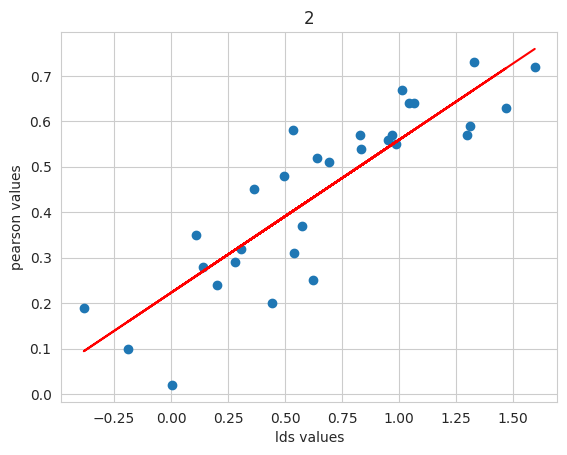

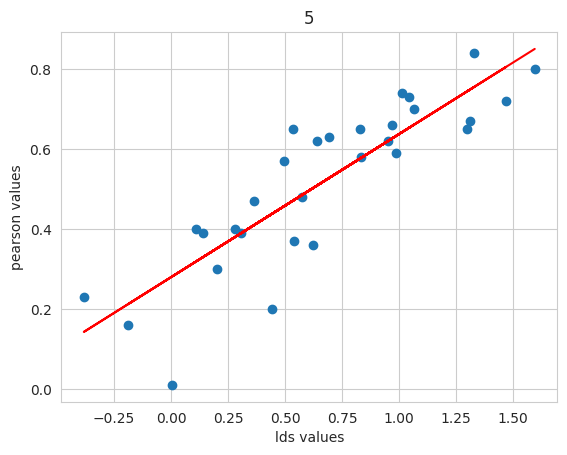

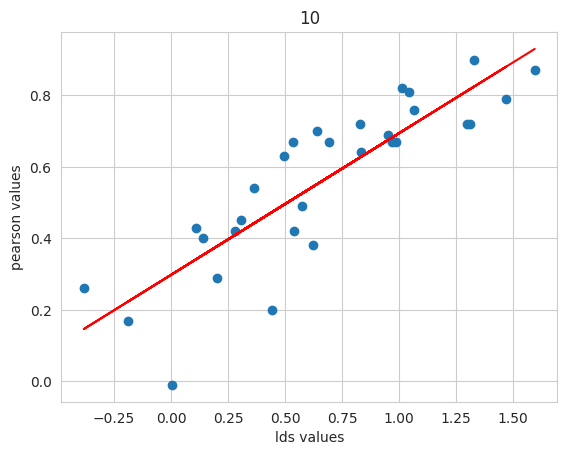

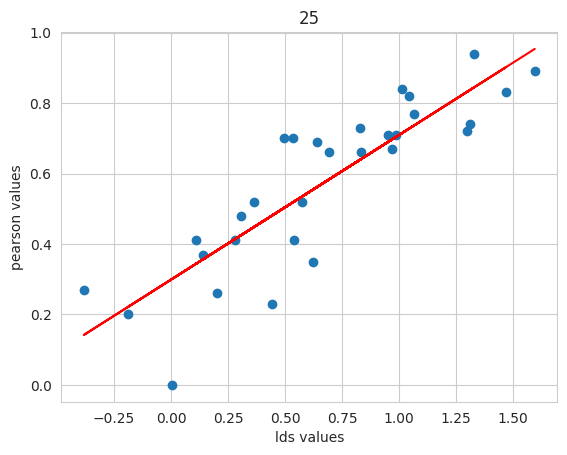

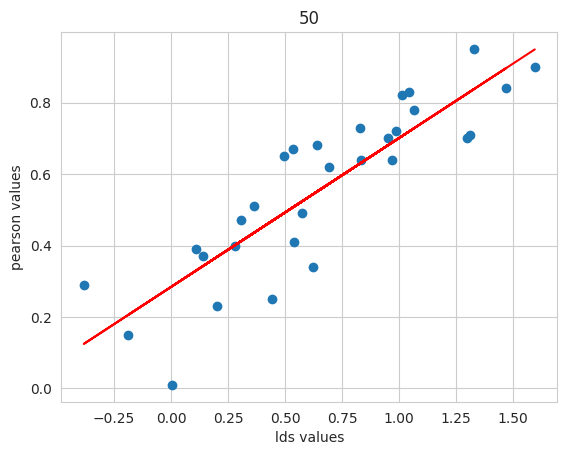

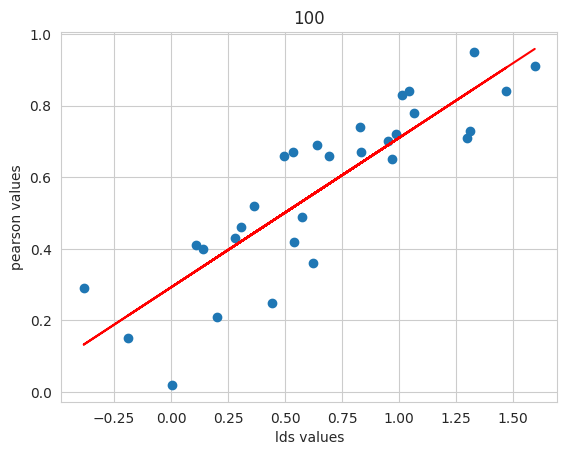

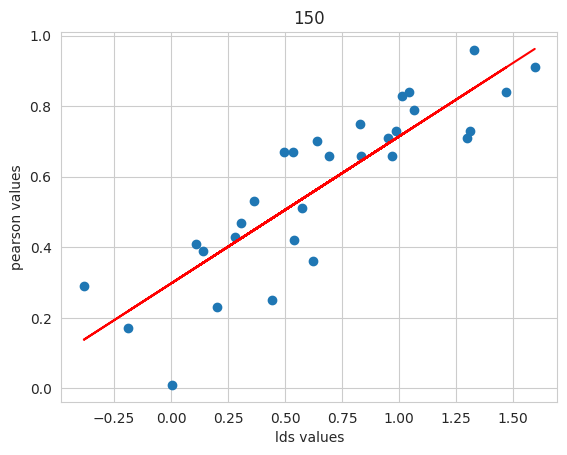

In [38]:
for k in list(k_wind):
    lds = df_correlation[df_correlation['k']==k]
    lds_values = lds['lds'].values
    pearson_values = lds['pearson'].values
    lds_values = lds_values[:, np.newaxis]

    reg = LinearRegression()
    reg.fit(lds_values, pearson_values)
    predict = reg.predict(lds_values)

    plt.title(k)
    plt.plot(lds_values, predict, color='red')
    plt.scatter(lds_values, pearson_values)
    plt.xlabel('lds values')
    plt.ylabel('pearson values')
    plt.show()

### Scatter correlation plot between SIAS values and Pearson

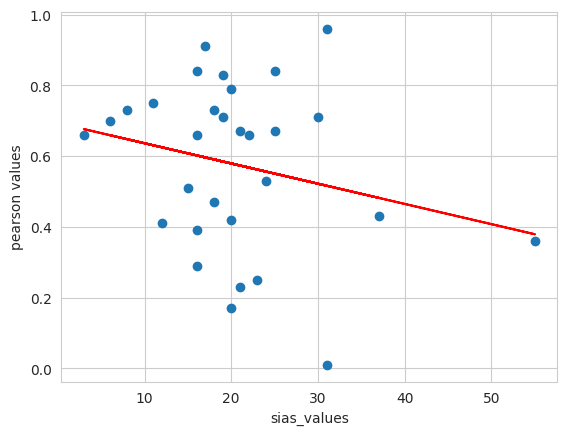

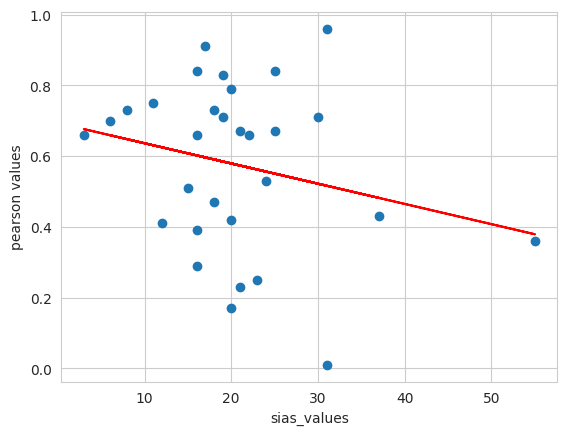

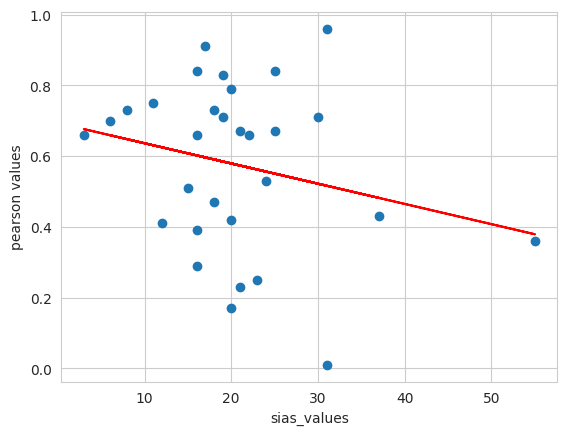

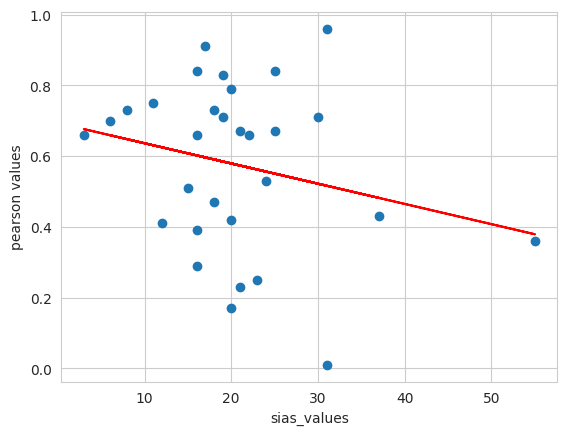

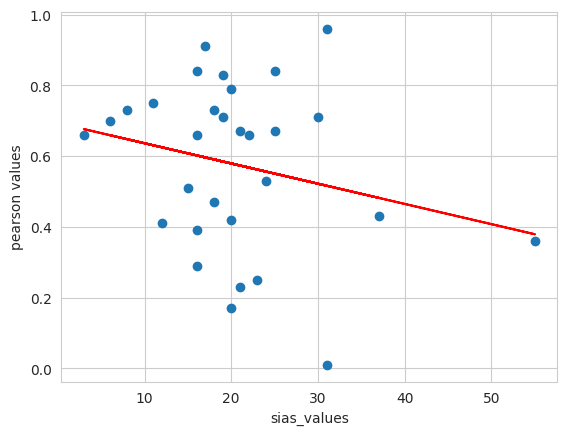

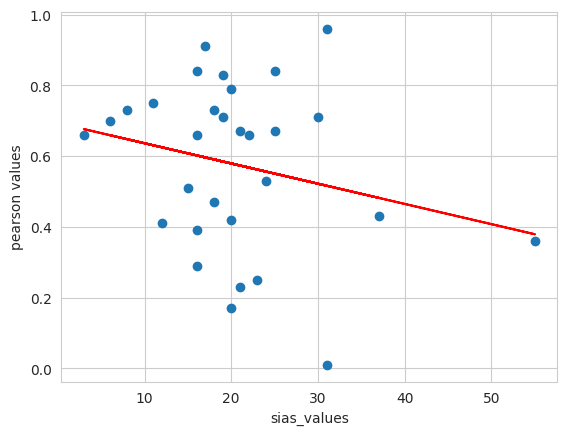

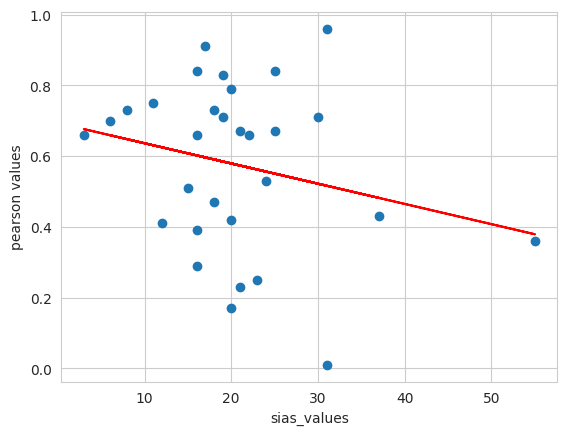

In [39]:
for k in list(k_wind):
    lds = df_correlation[df_correlation['k']==k]

    sias_values = lds['sias_score'].values
    sias_values = sias_values[:, np.newaxis]

    reg_sias = LinearRegression()
    reg_sias.fit(sias_values, pearson_values)
    predict_sias = reg_sias.predict(sias_values)

    plt.plot(sias_values, predict_sias, color='red')
    plt.scatter(sias_values, pearson_values)
    plt.xlabel('sias_values')
    plt.ylabel('pearson values')
    plt.show()